In [114]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers

# Load the data
# 'papers' is currently not being used in this code
papers = pd.read_csv('database_clean.csv')
embeddings_df = pd.read_csv("use_embeddings.csv")

embeddings_df_clean = embeddings_df.drop(columns=["Id"])

embeddings = embeddings_df_clean.values

# train 70%, val 20%, test 10%
X_train, X_temp = train_test_split(embeddings, test_size=0.3, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=1/3, random_state=42)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (385, 512), Validation: (110, 512), Test: (56, 512)


In [115]:
# Since the dataset is very small, the autodecoder model must be simple to reduce overfitting.
input_dim = X_train.shape[1]  

encoder = keras.Sequential([
    layers.InputLayer(input_shape=(input_dim,)),
    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
])

decoder = keras.Sequential([
    layers.Dense(input_dim, activation="sigmoid")  
])

input_layer = layers.Input(shape=(input_dim,))
encoded = encoder(input_layer)
decoded = decoder(encoded)

autoencoder = keras.Model(input_layer, decoded)
# To reduce overfitting
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=optimizer, loss="mse")

autoencoder.summary()

C:\Users\eyoel\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "functional_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_62 (InputLayer)          │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_40 (Sequential)           │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_41 (Sequential)           │ (None, 512)                 │          33,280 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,112 (258.25 KB)

 Trainable params: 66,112 (258.25 KB)

 Non-trainable params: 0 (0.00 B)

In [116]:
history = autoencoder.fit(
    X_train, X_train,
    epochs= 50,
    batch_size=32,
    validation_data=(X_val, X_val),
    shuffle=True
)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3784 - val_loss: 1.3455
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3351 - val_loss: 1.3030
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2930 - val_loss: 1.2620
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2521 - val_loss: 1.2224
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2129 - val_loss: 1.1841
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1750 - val_loss: 1.1471
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1383 - val_loss: 1.1114
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1028 - val_loss: 1.0768
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0686 - val_loss: 1.0434
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0353 - val_loss: 1.0109
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0031 - val_loss: 0.9795
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9718 - val_lo

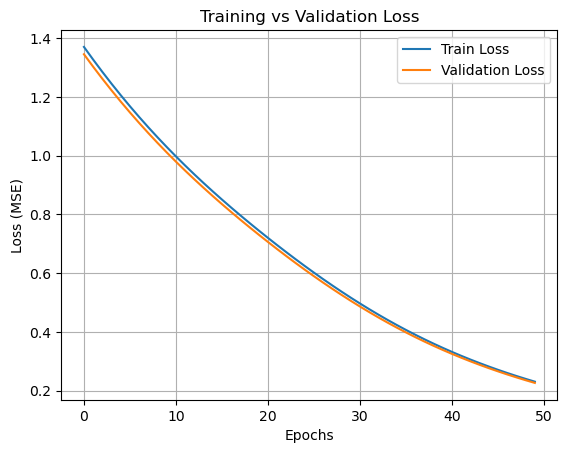

In [117]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [123]:
# Evaluate how well the autoencoder model encodes
from sklearn.metrics import mean_squared_error

reconstructed_test = autoencoder.predict(X_test)

mse = mean_squared_error(X_test, reconstructed_test)

# MSE for test is much smaller than MSE for loss and val_loss. Why?
print(f"Mean Squared Error (MSE) on the test set: {mse:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Mean Squared Error (MSE) on the test set: 0.0642


In [118]:
# Encode the train and test set using the autoencoder's encoder
encoded_train = encoder.predict(X_train)
encoded_test = encoder.predict(X_test)

# Calculate the similarity matrix for both the original and encoded versions
similarity_matrix = cosine_similarity(X_test, X_train)
similarity_matrix_encoded = cosine_similarity(encoded_test, encoded_train)

# Sort the similarity matrix in reverse order and select the top 10 data points
top_n = 10
top_indices = np.argsort(-similarity_matrix_encoded, axis=1)[:, :top_n]  

# Print and store the id of the recommended papers
recommended_paper_ids = []

for i, test_idx in enumerate(top_indices):
    recommended_for_test = []
    print(f"\nTest Paper {i+1}:")
    for j, train_idx in enumerate(test_idx):
        recommended_paper_id = papers.iloc[train_idx]["Id"]
        recommended_for_test.append(recommended_paper_id)
        print(f"  {j+1}. Recommended Paper ID: {recommended_paper_id} (Encoded_Similarity: {similarity_matrix_encoded[i, train_idx]:.4f}) (Similarity: {similarity_matrix[i, train_idx]:.4f})")
    recommended_paper_ids.append(recommended_for_test)

# Sort the similarity matrix in reverse order and select the top 10 data points
top_n = 10
top_indices = np.argsort(-similarity_matrix, axis=1)[:, :top_n]  

# Print and store the id of the recommended papers
best_paper_ids = []

for i, test_idx in enumerate(top_indices):
    best_for_test = []
    print(f"\nTest Paper {i+1}:")
    for j, train_idx in enumerate(test_idx):
        best_paper_id = papers.iloc[train_idx]["Id"]
        best_for_test.append(best_paper_id)
        print(f"  {j+1}. Unencoded Recommended Paper ID: {best_paper_id} (Similarity: {similarity_matrix[i, train_idx]:.4f}) (Encoded_Similarity: {similarity_matrix_encoded[i, train_idx]:.4f})")
    best_paper_ids.append(best_for_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Test Paper 1:
  1. Recommended Paper ID: 330 (Encoded_Similarity: 0.9978) (Similarity: 0.6709)
  2. Recommended Paper ID: 374 (Encoded_Similarity: 0.9974) (Similarity: 0.5925)
  3. Recommended Paper ID: 231 (Encoded_Similarity: 0.9972) (Similarity: 0.6366)
  4. Recommended Paper ID: 111 (Encoded_Similarity: 0.9971) (Similarity: 0.5876)
  5. Recommended Paper ID: 148 (Encoded_Similarity: 0.9971) (Similarity: 0.5653)
  6. Recommended Paper ID: 5 (Encoded_Similarity: 0.9971) (Similarity: 0.6476)
  7. Recommended Paper ID: 193 (Encoded_Similarity: 0.9970) (Similarity: 0.5623)
  8. Recommended Paper ID: 96 (Encoded_Similarity: 0.9970) (Similarity: 0.6232)
  9. Recommended Paper ID: 286 (Encoded_Similarity: 0.9970) (Similarity: 0.6669)
  10. Recommended Paper ID: 179 (Encoded_Similarity: 0.9969) (Similarity: 0.6158)

Test Paper 2:
  1. Recommended Paper ID: 190 (Encoded_Similarity: 0.9978) (Similarity: 0.6196)
  2.

In [119]:
# Calculates the percentages of how many recommended papers using the autoencoder exist in the recommended papers without using the autoencoder for each test paper
overlap_percentages = []

for recommended, best in zip(recommended_paper_ids, best_paper_ids):
    recommended_set = set(recommended)
    best_set = set(best)
    
    intersection = recommended_set.intersection(best_set)
    
    overlap_percentage = len(intersection) / len(best_set) * 100
    
    overlap_percentages.append(overlap_percentage)

average_overlap = sum(overlap_percentages) / len(overlap_percentages)

for i, overlap in enumerate(overlap_percentages):
    print(f"Test Paper {i+1}: {overlap:.2f}% overlap")

# Calculates the average overlap percentage for all test papers
print(f"\nAverage overlap: {average_overlap:.2f}%")

Test Paper 1: 50.00% overlap
Test Paper 2: 50.00% overlap
Test Paper 3: 50.00% overlap
Test Paper 4: 40.00% overlap
Test Paper 5: 60.00% overlap
Test Paper 6: 50.00% overlap
Test Paper 7: 30.00% overlap
Test Paper 8: 60.00% overlap
Test Paper 9: 50.00% overlap
Test Paper 10: 30.00% overlap
Test Paper 11: 30.00% overlap
Test Paper 12: 30.00% overlap
Test Paper 13: 40.00% overlap
Test Paper 14: 50.00% overlap
Test Paper 15: 50.00% overlap
Test Paper 16: 30.00% overlap
Test Paper 17: 40.00% overlap
Test Paper 18: 40.00% overlap
Test Paper 19: 30.00% overlap
Test Paper 20: 20.00% overlap
Test Paper 21: 40.00% overlap
Test Paper 22: 40.00% overlap
Test Paper 23: 40.00% overlap
Test Paper 24: 30.00% overlap
Test Paper 25: 40.00% overlap
Test Paper 26: 40.00% overlap
Test Paper 27: 40.00% overlap
Test Paper 28: 10.00% overlap
Test Paper 29: 50.00% overlap
Test Paper 30: 40.00% overlap
Test Paper 31: 60.00% overlap
Test Paper 32: 30.00% overlap
Test Paper 33: 60.00% overlap
Test Paper 34: 50.0

In [121]:
# Saves the model
autoencoder.save('autoencoder_model.keras')